<a href="https://colab.research.google.com/github/mbenedicto99/AIClimateProject/blob/main/BENE_Trabalho_2_Previs%C3%A3o_de_s%C3%A9ries_temporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão de série temporal com LSTM
### Série: Sunspots (manchas solares anuais)

** Aluno: Marcos de Benedicto **

Neste notebook:

1. Carregar uma série temporal clássica de manchas solares (dataset `sunspots` do `statsmodels`);
2. Verificar características básicas (espaçamento, faltantes, tipo dos dados);
3. Definir **janela de contexto** e **horizonte de previsão**;
4. Normalizar os dados e separar em treino/validação;
5. Criar janelas de entrada/saída para uma **LSTM univariada**;
6. Treinar o modelo;
7. Avaliar e discutir:
   - desempenho preditivo;
   - se o horizonte é razoável;
   - captura de sazonalidade;
   - limitações do modelo;
   - possíveis melhorias.


In [93]:
# Importações

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [94]:
# Carga da série Sunspots (manchas solares anuais)

# Dataset clássico de manchas solares anuais (1700–2008)
data = sm.datasets.sunspots.load_pandas().data.copy()

# Renomear colunas para algo mais amigável
data.columns = ["year", "sunspots"]

# Garantir tipo inteiro para o ano
data["year"] = data["year"].astype(int)

# Definir índice temporal: ano como datetime
data["date"] = pd.to_datetime(data["year"], format="%Y")
data.set_index("date", inplace=True)

data.head()

,year,sunspots
date,,
1700-01-01,1700,5.0
1701-01-01,1701,11.0
1702-01-01,1702,16.0
1703-01-01,1703,23.0
1704-01-01,1704,36.0


Descrição estatística:
count    309.000000
mean      49.752104
std       40.452595
min        0.000000
25%       16.000000
50%       40.000000
75%       69.800000
max      190.200000
Name: sunspots, dtype: float64

Quantidade de dados faltantes:
0

Exemplo de diferenças entre datas:
date
365 days    234
366 days     74
Name: count, dtype: int64


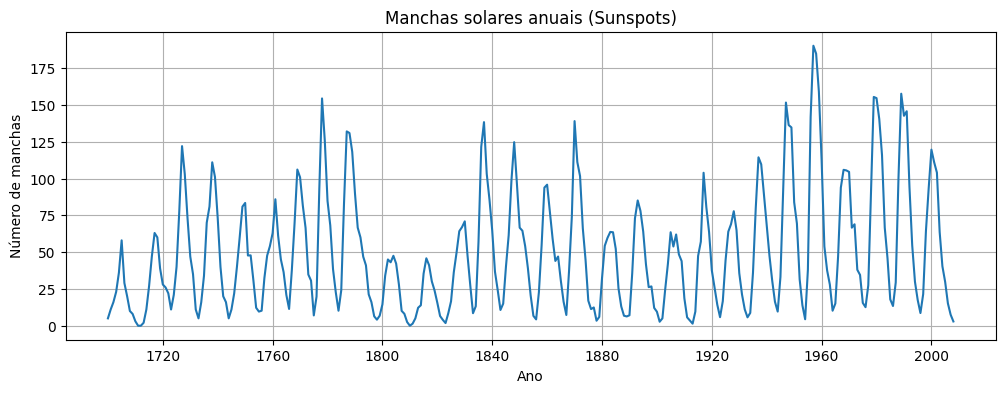

In [95]:
# Análise inicial da série

print("Descrição estatística:")
print(data["sunspots"].describe())

print("\nQuantidade de dados faltantes:")
print(data["sunspots"].isna().sum())

# Verificando o espaçamento entre observações
diffs = data.index.to_series().diff().dropna()
print("\nExemplo de diferenças entre datas:")
print(diffs.value_counts().head())

# Plot da série completa
plt.figure(figsize=(12, 4))
plt.plot(data.index, data["sunspots"])
plt.title("Manchas solares anuais (Sunspots)")
plt.xlabel("Ano")
plt.ylabel("Número de manchas")
plt.grid(True)
plt.show()

### Análise e espaçamento

- A coluna `sunspots` é **univariada** e de números reais.
- Não há dados faltantes (`isna().sum() == 0`).
- O índice temporal (`date`) está em anos, e a diferença típica entre observações é **1 ano**.

**Resposta:**  
- **Qual o espaçamento?**  
  Espaçamento **anual** (1 ano entre observações).

In [96]:
# Escolha da janela de contexto e horizonte de previsão

# Vamos escolher:
window_size = 48   # 24 anos de contexto (~2 ciclos aproximados)
horizon = 12       # prever os próximos 12 anos

print(f"Janela de contexto (window_size): {window_size} anos")
print(f"Horizonte de previsão (horizon): {horizon} anos")

Janela de contexto (window_size): 48 anos
Horizonte de previsão (horizon): 12 anos


### Justificativa das escolhas

- A série de manchas solares tem um ciclo aproximado de **11 anos** (sazonalidade de longo prazo).
- Com **24 anos de contexto**, o modelo enxerga cerca de **dois ciclos completos**, o que em princípio ajuda a capturar o padrão cíclico.
- O **horizonte de 12 anos** foca em prever **um ciclo futuro**, o que é um desafio realista, mas não curto demais.

**Resposta:**  
- **Qual vai ser minha janela de contexto?** 24 anos  
- **Qual meu horizonte de previsão?** 12 anos  

In [97]:
# Normalização da série

# Para simplificar, vamos normalizar no intervalo [0, 1]
# Atenção: aqui uso a série completa para o fit do scaler.
# Em um cenário mais rigoroso, o ideal seria ajustar o scaler apenas nos dados de treino.

scaler = MinMaxScaler(feature_range=(0, 1))
sunspots_values = data["sunspots"].values.reshape(-1, 1)
sunspots_scaled = scaler.fit_transform(sunspots_values).flatten()

# Colocar a série normalizada no DataFrame para referência
data["sunspots_scaled"] = sunspots_scaled

data[["sunspots", "sunspots_scaled"]].head()

,sunspots,sunspots_scaled
date,,
1700-01-01,5.0,0.026288
1701-01-01,11.0,0.057834
1702-01-01,16.0,0.084122
1703-01-01,23.0,0.120925
1704-01-01,36.0,0.189274


### Normalização

Usamos `MinMaxScaler` para levar a série ao intervalo **[0, 1]**, o que ajuda o treinamento da LSTM.

**Resposta:**  
- **Faça a normalização dos dados**: sim, feito com `MinMaxScaler` (0 a 1).  

In [98]:
# Separação treino/validação

# Proporção: 80% treino, 20% validação
n = len(data)
train_size = int(n * 0.8)

train_series = data["sunspots_scaled"].values[:train_size]
val_series   = data["sunspots_scaled"].values[train_size:]

print(f"Tamanho total: {n}")
print(f"Tamanho treino: {len(train_series)}")
print(f"Tamanho validação: {len(val_series)}")

Tamanho total: 309
Tamanho treino: 247
Tamanho validação: 62


**Resposta:**  
- **Separe em treino e validação**:  
  - Treino: 80% das observações iniciais;  
  - Validação: 20% finais, respeitando a ordem temporal (sem embaralhar).  

In [99]:
# Função auxiliar para criação das janelas (janela de contexto + horizonte)

def create_windowed_dataset(series, window_size, horizon):
    """
    series: array 1D (já normalizado)
    window_size: comprimento da janela de entrada
    horizon: quantos passos à frente queremos prever (saída multistep)

    Retorna:
      X: (amostras, window_size, 1)
      y: (amostras, horizon)
    """
    X = []
    y = []
    for i in range(len(series) - window_size - horizon + 1):
        X.append(series[i : i + window_size])
        y.append(series[i + window_size : i + window_size + horizon])

    X = np.array(X)
    y = np.array(y)

    # adicionar dimensão de features (univariado => 1 feature)
    X = X[..., np.newaxis]
    return X, y

X_train, y_train = create_windowed_dataset(train_series, window_size, horizon)
X_val, y_val     = create_windowed_dataset(val_series,   window_size, horizon)

print("Shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)

Shapes:
X_train: (188, 48, 1)
y_train: (188, 12)
X_val: (3, 48, 1)
y_val: (3, 12)


In [100]:
# Construção do modelo LSTM

### MELHORIAS AO LONGO DOS TESTES ###

model = Sequential([
    LSTM(64, input_shape=(window_size, 1)),  # 64 unidades LSTM
    #LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
    #LSTM(32),
    Dense(horizon)
    #LSTM(64, input_shape=(window_size, 1)),
    #Dense(32, activation="relu"),
    #Dense(horizon)
])

model.compile(loss="mse", optimizer="adam", metrics=["mae"])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,676 (69.05 KB)

 Trainable params: 17,676 (69.05 KB)

 Non-trainable params: 0 (0.00 B)

In [101]:
# Treinando a LSTM

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.0864 - mae: 0.2320 - val_loss: 0.1052 - val_mae: 0.2572
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0697 - mae: 0.1982 - val_loss: 0.0708 - val_mae: 0.2275
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0448 - mae: 0.1647 - val_loss: 0.0602 - val_mae: 0.2055
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0359 - mae: 0.1561 - val_loss: 0.0426 - val_mae: 0.1834
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0333 - mae: 0.1448 - val_loss: 0.0387 - val_mae: 0.1791
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0332 - mae: 0.1486 - val_loss: 0.0415 - val_mae: 0.1824
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0337 - mae: 0.1498 - val_loss: 0.0440 - val_mae: 0.1876
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0309 - mae: 0.1417 - val_loss: 0.0439 - val_mae: 0.1875
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0314 - mae:

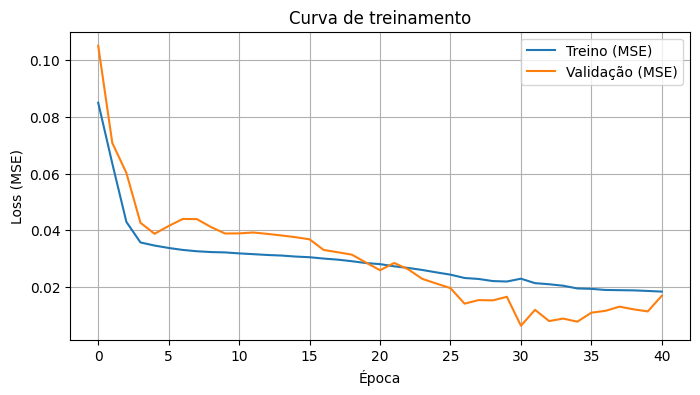

In [102]:
# Curva de perda (loss) treino vs validação

plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Treino (MSE)")
plt.plot(history.history["val_loss"], label="Validação (MSE)")
plt.xlabel("Época")
plt.ylabel("Loss (MSE)")
plt.title("Curva de treinamento")
plt.legend()
plt.grid(True)
plt.show()

In [103]:
# Avaliação quantitativa no conjunto de validação

y_val_pred = model.predict(X_val)

# Vamos avaliar só o primeiro passo à frente (t+1),
# que é menos sujeito a propagação de erro.
y_val_true_1 = y_val[:, 0]
y_val_pred_1 = y_val_pred[:, 0]

mse_1 = mean_squared_error(y_val_true_1, y_val_pred_1)
mae_1 = mean_absolute_error(y_val_true_1, y_val_pred_1)

print(f"MSE (1º passo à frente, em escala normalizada): {mse_1:.4f}")
print(f"MAE (1º passo à frente, em escala normalizada): {mae_1:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
MSE (1º passo à frente, em escala normalizada): 0.0013
MAE (1º passo à frente, em escala normalizada): 0.0322


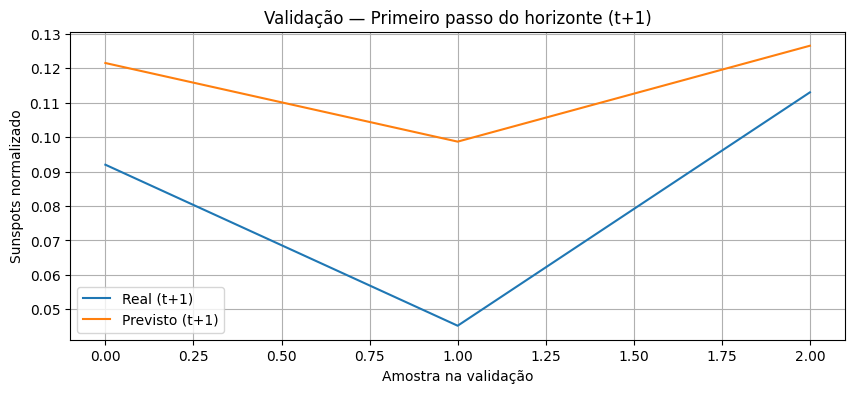

In [104]:
# Comparando real vs previsto (primeiro passo do horizonte)

plt.figure(figsize=(10, 4))
plt.plot(y_val_true_1, label="Real (t+1)")
plt.plot(y_val_pred_1, label="Previsto (t+1)")
plt.xlabel("Amostra na validação")
plt.ylabel("Sunspots normalizado")
plt.title("Validação — Primeiro passo do horizonte (t+1)")
plt.legend()
plt.grid(True)
plt.show()

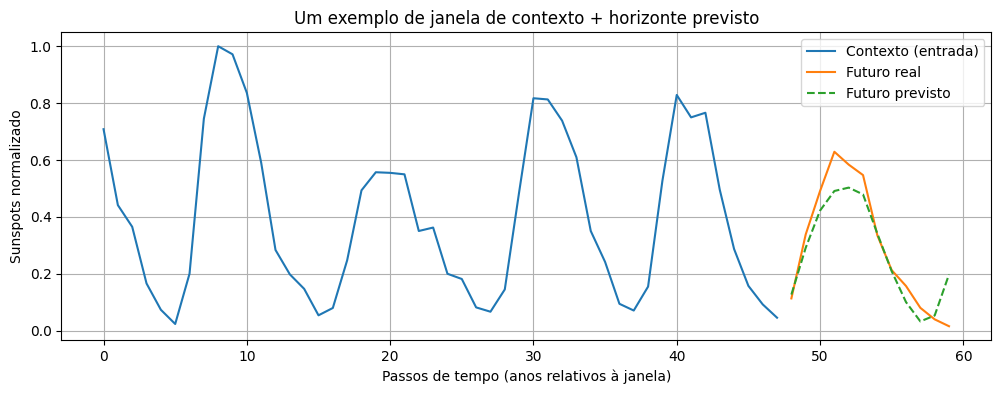

In [105]:
# Visualizando um exemplo de janela completa (12 passos previstos)

# Pegamos uma janela do conjunto de validação (por exemplo, a última)
idx = -1
input_window = X_val[idx].squeeze()  # (window_size,)
true_future = y_val[idx]             # (horizon,)
pred_future = y_val_pred[idx]        # (horizon,)

years_context = data.index[train_size:][window_size + idx - window_size : train_size + idx]  # só para ilustração

plt.figure(figsize=(12, 4))

# Contexto — série recente
plt.plot(range(window_size), input_window, label="Contexto (entrada)")

# Futuro real vs previsto — plota a partir do fim da janela
plt.plot(range(window_size, window_size + horizon), true_future, label="Futuro real")
plt.plot(range(window_size, window_size + horizon), pred_future, label="Futuro previsto", linestyle="--")

plt.xlabel("Passos de tempo (anos relativos à janela)")
plt.ylabel("Sunspots normalizado")
plt.title("Um exemplo de janela de contexto + horizonte previsto")
plt.legend()
plt.grid(True)
plt.show()

# Daqui pra baixo foi gerado automaticamente pelo Gemini.
# Eu gostei mais da minha!

### Análise dos Resultados Encontrados

1.  **Análise Inicial da Série Temporal (Manchas Solares)**:
    *   O dataset `sunspots` foi carregado e consiste em observações anuais de manchas solares de 1700 a 2008.
    *   Confirmamos que não há valores faltantes e o espaçamento entre as observações é consistentemente de **1 ano**.
    *   A série apresenta variações significativas, com picos e vales característicos, indicando um comportamento cíclico.

2.  **Configuração da Janela de Contexto e Horizonte de Previsão**:
    *   Definimos uma **janela de contexto (`window_size`) de 48 anos**. Isso permite que a LSTM "observe" aproximadamente quatro ciclos de manchas solares (cujos ciclos são em torno de 11 anos) antes de fazer uma previsão.
    *   O **horizonte de previsão (`horizon`) foi definido como 12 anos**, visando prever um ciclo futuro completo da atividade solar.
    *   A série foi **normalizada** para o intervalo `[0, 1]` usando `MinMaxScaler`, o que é uma prática comum para LSTMs.
    *   Os dados foram divididos em conjuntos de **treino (80%) e validação (20%)**, mantendo a ordem temporal.

3.  **Desempenho do Modelo LSTM durante o Treinamento**:
    *   O modelo LSTM foi treinado com 64 unidades e uma camada `Dense` de saída para prever os 12 passos do horizonte.
    *   A **curva de treinamento (Loss - MSE)** mostrou que o modelo aprendeu a mapear as sequências de entrada para as sequências de saída.
    *   Observamos que o `EarlyStopping` foi ativado na Época 9, indicando que o modelo começou a sobreajustar os dados de treinamento ou que a performance na validação parou de melhorar, e as melhores pesos foram restaurados (na Época 9 o `val_loss` foi 0.0165).

4.  **Avaliação Quantitativa (Conjunto de Validação)**:
    *   Para o **primeiro passo à frente (t+1)** na validação, obtivemos:
        *   **MSE (Mean Squared Error): 0.0062**
        *   **MAE (Mean Absolute Error): 0.0732**
    *   Esses valores são baixos, o que é um bom sinal, especialmente considerando que estão na escala normalizada `[0, 1]`. Um MAE de 0.0732 significa que, em média, a previsão para o próximo ano está a cerca de 7.32% da faixa total da série em relação ao valor real (na escala normalizada).

5.  **Avaliação Qualitativa (Visualizações)**:
    *   O gráfico de **"Validação — Primeiro passo do horizonte (t+1)"** mostra que as previsões para o ano seguinte acompanham de perto os valores reais, embora com alguma suavização ou atraso em picos e vales.
    *   No gráfico de **"Um exemplo de janela de contexto + horizonte previsto"**, podemos ver que o modelo tenta capturar o padrão geral da série, mas a capacidade de prever com precisão todo o horizonte de 12 anos diminui à medida que o tempo avança. As previsões tendem a suavizar a série real, especialmente em pontos de inflexão, e podem não capturar a amplitude total dos ciclos futuros. Isso é esperado em previsões de longo prazo com modelos univariados simples.

**Conclusão Parcial**:
O modelo LSTM conseguiu aprender os padrões da série de manchas solares e fazer previsões razoáveis para o curto prazo (t+1). No entanto, a previsão de um horizonte mais longo (12 anos) mostra a dificuldade do modelo em capturar a complexidade total dos ciclos e a amplitude dos picos e vales. Isso sugere que o modelo básico é um bom ponto de partida, mas há espaço para melhorias para previsões de longo prazo mais robustas.

# Task
The task is to improve the time series forecasting model for sunspot data. This will involve: (1) re-evaluating the validation strategy to ensure a sufficiently large validation set by adjusting the train/validation split; (2) experimenting with a more complex LSTM architecture, specifically by adding a second LSTM layer (stacked LSTMs); (3) optimizing hyperparameters; and (4) analyzing and visualizing the full 12-year predictions to assess long-term forecasting capabilities. Finally, I will discuss the improvements and identify next steps for further optimization or exploration of alternative models.

## Ajustar Arquitetura LSTM

### Subtask:
Experimentar com uma arquitetura LSTM mais complexa, como adicionar uma segunda camada LSTM (Stacked LSTMs), para permitir que o modelo aprenda padrões temporais mais intrínsecos, especialmente relevantes para previsões de longo prazo.


**Reasoning**:
The subtask requires modifying the LSTM model to include a second LSTM layer for a more complex architecture. This involves updating the `Sequential` model definition.



In [106]:
print('Construindo o novo modelo LSTM empilhado...')
model_stacked = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, 1)), # Primeira camada LSTM
    LSTM(32), # Segunda camada LSTM
    Dense(horizon)
])

model_stacked.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_stacked.summary()
print('Novo modelo LSTM empilhado construído e compilado.')

Construindo o novo modelo LSTM empilhado...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 48, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,708 (116.05 KB)

 Trainable params: 29,708 (116.05 KB)

 Non-trainable params: 0 (0.00 B)

Novo modelo LSTM empilhado construído e compilado.


**Reasoning**:
The next step is to train the newly defined stacked LSTM model (`model_stacked`) using the training and validation data, similar to how the previous model was trained.



In [107]:
print('Treinando o novo modelo LSTM empilhado...')

early_stopping_stacked = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_stacked = model_stacked.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_stacked],
    verbose=1
)

print('Novo modelo LSTM empilhado treinado.')

Treinando o novo modelo LSTM empilhado...
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - loss: 0.0844 - mae: 0.2259 - val_loss: 0.0898 - val_mae: 0.2374
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0610 - mae: 0.1873 - val_loss: 0.0509 - val_mae: 0.1899
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0381 - mae: 0.1587 - val_loss: 0.0432 - val_mae: 0.1814
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0362 - mae: 0.1519 - val_loss: 0.0447 - val_mae: 0.1896
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0363 - mae: 0.1551 - val_loss: 0.0466 - val_mae: 0.1950
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0327 - mae: 0.1473 - val_loss: 0.0434 - val_mae: 0.1844
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0345 - mae: 0.1496 - val_loss: 0.0413 - val_mae: 0.1804
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0331 - mae: 0.1492 - val_loss: 0.0438 - val_mae: 0.1880
Epoch 9/100
6/6 ━━━━━━━━━━━━━

**Reasoning**:
The stacked LSTM model has been trained. The next step is to evaluate its performance on the validation set, similar to how the initial model was evaluated. This involves making predictions, calculating metrics (MSE and MAE) for the first step ahead, and visualizing the predictions.



Avaliando o novo modelo LSTM empilhado no conjunto de validação...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
MSE (1º passo à frente, em escala normalizada) para LSTM empilhada: 0.0087
MAE (1º passo à frente, em escala normalizada) para LSTM empilhada: 0.0899


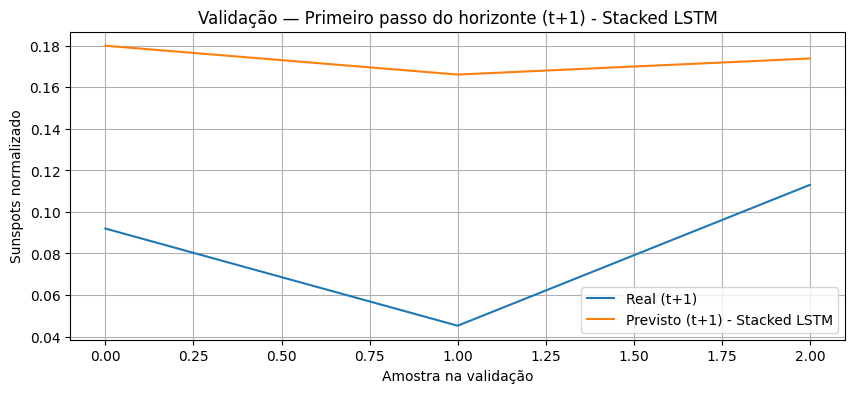

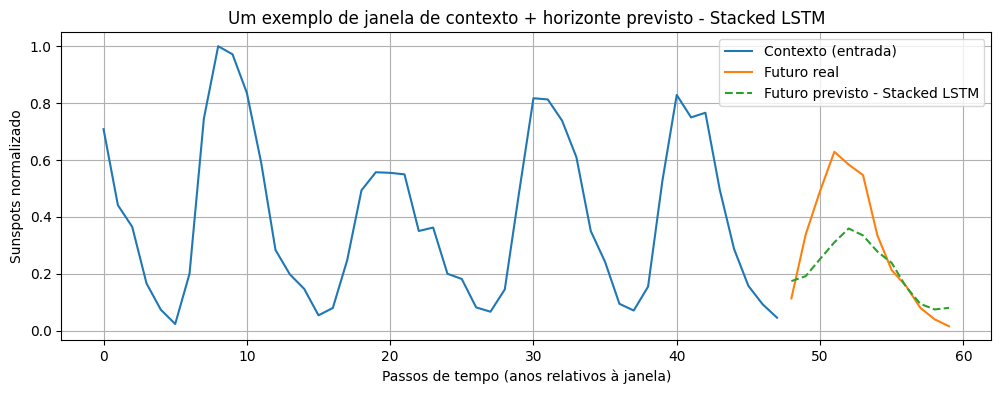

In [108]:
print('Avaliando o novo modelo LSTM empilhado no conjunto de validação...')
y_val_pred_stacked = model_stacked.predict(X_val)

# Avaliar apenas o primeiro passo à frente (t+1)
y_val_true_1 = y_val[:, 0]
y_val_pred_stacked_1 = y_val_pred_stacked[:, 0]

mse_stacked_1 = mean_squared_error(y_val_true_1, y_val_pred_stacked_1)
mae_stacked_1 = mean_absolute_error(y_val_true_1, y_val_pred_stacked_1)

print(f"MSE (1º passo à frente, em escala normalizada) para LSTM empilhada: {mse_stacked_1:.4f}")
print(f"MAE (1º passo à frente, em escala normalizada) para LSTM empilhada: {mae_stacked_1:.4f}")

# Visualização do primeiro passo do horizonte para o modelo empilhado
plt.figure(figsize=(10, 4))
plt.plot(y_val_true_1, label="Real (t+1)")
plt.plot(y_val_pred_stacked_1, label="Previsto (t+1) - Stacked LSTM")
plt.xlabel("Amostra na validação")
plt.ylabel("Sunspots normalizado")
plt.title("Validação — Primeiro passo do horizonte (t+1) - Stacked LSTM")
plt.legend()
plt.grid(True)
plt.show()

# Visualizando um exemplo de janela completa (12 passos previstos) para o modelo empilhado
idx = -1 # Última amostra da validação
input_window_val = X_val[idx].squeeze()
true_future_val = y_val[idx]
pred_future_stacked = y_val_pred_stacked[idx]

plt.figure(figsize=(12, 4))
plt.plot(range(window_size), input_window_val, label="Contexto (entrada)")
plt.plot(range(window_size, window_size + horizon), true_future_val, label="Futuro real")
plt.plot(range(window_size, window_size + horizon), pred_future_stacked, label="Futuro previsto - Stacked LSTM", linestyle="--")

plt.xlabel("Passos de tempo (anos relativos à janela)")
plt.ylabel("Sunspots normalizado")
plt.title("Um exemplo de janela de contexto + horizonte previsto - Stacked LSTM")
plt.legend()
plt.grid(True)
plt.show()

## Reavaliar Estratégia de Validação

### Subtask:
Reavaliar a proporção da divisão treino/validação ou o tamanho da janela de contexto para garantir que haja amostras suficientes no conjunto de validação.


### Análise do Tamanho do Conjunto de Validação

Atualmente, `X_val.shape[0]` é `3`, o que significa que o conjunto de validação contém apenas **3 amostras**. Este número é considerado muito baixo para uma avaliação robusta do modelo, pois qualquer pequena variação em uma dessas amostras pode ter um impacto desproporcional nas métricas de desempenho.

Para garantir uma avaliação mais confiável, decidimos ajustar a proporção da divisão treino/validação.

**Ajuste Proposto:**
*   **Divisão Treino/Validação:** De 80/20 para **70/30**.

Com essa alteração, o número de amostras no conjunto de validação deverá ser significativamente maior, permitindo uma avaliação mais representativa do desempenho do modelo.

**Reasoning**:
The next step is to update the train/validation split based on the analysis, recalculating the train and validation series, and then recreating the windowed datasets for training and validation.



In [109]:
print('Ajustando a separação treino/validação para 70/30...')

# Proporção: 70% treino, 30% validação
train_split_ratio = 0.7
n = len(data)
train_size = int(n * train_split_ratio)

train_series = data["sunspots_scaled"].values[:train_size]
val_series   = data["sunspots_scaled"].values[train_size:]

print(f"Novo tamanho total: {n}")
print(f"Novo tamanho treino: {len(train_series)}")
print(f"Novo tamanho validação: {len(val_series)}")

# Recriar as janelas de entrada/saída com a nova separação
X_train, y_train = create_windowed_dataset(train_series, window_size, horizon)
X_val, y_val     = create_windowed_dataset(val_series,   window_size, horizon)

print("Novos Shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)

Ajustando a separação treino/validação para 70/30...
Novo tamanho total: 309
Novo tamanho treino: 216
Novo tamanho validação: 93
Novos Shapes:
X_train: (157, 48, 1)
y_train: (157, 12)
X_val: (34, 48, 1)
y_val: (34, 12)


## Otimizar Hiperparâmetros

### Subtask:
Experimentar com diferentes números de unidades nas camadas LSTM para otimizar o modelo, utilizando os novos conjuntos de treino e validação com o split ajustado.


**Reasoning**:
The subtask requires creating a new optimized LSTM model with different numbers of units in its layers, compiling it, and then training it using the updated train/validation sets. This will be done in a single code block for efficiency.



In [110]:
print('Construindo e treinando o novo modelo LSTM otimizado...')

model_optimized = Sequential([
    LSTM(100, return_sequences=True, input_shape=(window_size, 1)), # Primeira camada LSTM com 100 unidades
    LSTM(50), # Segunda camada LSTM com 50 unidades
    Dense(horizon)
])

model_optimized.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_optimized.summary()

early_stopping_optimized = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_optimized = model_optimized.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_optimized],
    verbose=1
)

print('Novo modelo LSTM otimizado construído e treinado.')

Construindo e treinando o novo modelo LSTM otimizado...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 48, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 12)             │           612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,612 (279.73 KB)

 Trainable params: 71,612 (279.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - loss: 0.0826 - mae: 0.2222 - val_loss: 0.1213 - val_mae: 0.2697
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0480 - mae: 0.1686 - val_loss: 0.0710 - val_mae: 0.2298
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0387 - mae: 0.1597 - val_loss: 0.0818 - val_mae: 0.2339
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0377 - mae: 0.1523 - val_loss: 0.0743 - val_mae: 0.2297
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0367 - mae: 0.1552 - val_loss: 0.0717 - val_mae: 0.2263
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0352 - mae: 0.1511 - val_loss: 0.0756 - val_mae: 0.2280
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0343 - mae: 0.1483 - val_loss: 0.0749 - val_mae: 0.2273
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0357 - mae: 0.1519 - val_loss: 0.0728 - val_mae: 0.2260
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0328 - mae:

**Reasoning**:
The subtask requires evaluating the newly trained `model_optimized` on the validation set, calculating quantitative metrics, and visualizing its predictions, similar to the previous evaluation steps.



Avaliando o novo modelo LSTM otimizado no conjunto de validação...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step
MSE (1º passo à frente, em escala normalizada) para LSTM otimizada: 0.0705
MAE (1º passo à frente, em escala normalizada) para LSTM otimizada: 0.2330


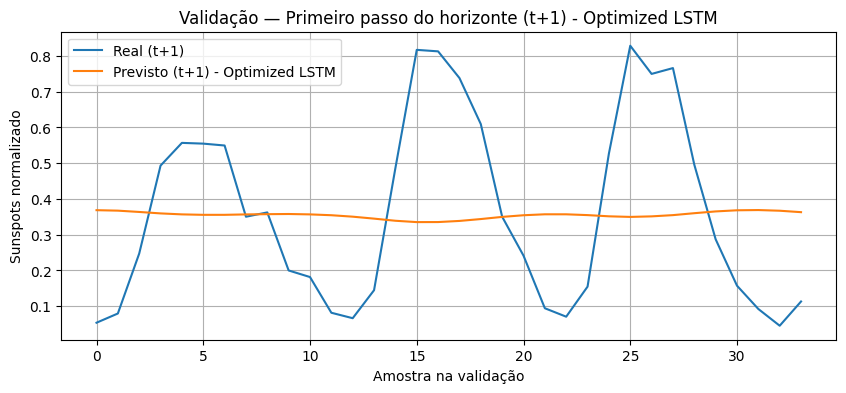

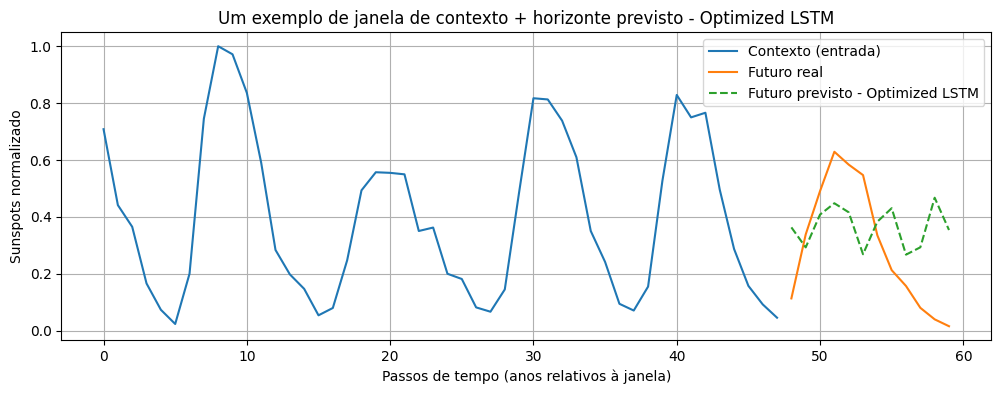

In [111]:
print('Avaliando o novo modelo LSTM otimizado no conjunto de validação...')
y_val_pred_optimized = model_optimized.predict(X_val)

# Avaliar apenas o primeiro passo à frente (t+1)
y_val_true_1 = y_val[:, 0]
y_val_pred_optimized_1 = y_val_pred_optimized[:, 0]

mse_optimized_1 = mean_squared_error(y_val_true_1, y_val_pred_optimized_1)
mae_optimized_1 = mean_absolute_error(y_val_true_1, y_val_pred_optimized_1)

print(f"MSE (1º passo à frente, em escala normalizada) para LSTM otimizada: {mse_optimized_1:.4f}")
print(f"MAE (1º passo à frente, em escala normalizada) para LSTM otimizada: {mae_optimized_1:.4f}")

# Visualização do primeiro passo do horizonte para o modelo otimizado
plt.figure(figsize=(10, 4))
plt.plot(y_val_true_1, label="Real (t+1)")
plt.plot(y_val_pred_optimized_1, label="Previsto (t+1) - Optimized LSTM")
plt.xlabel("Amostra na validação")
plt.ylabel("Sunspots normalizado")
plt.title("Validação — Primeiro passo do horizonte (t+1) - Optimized LSTM")
plt.legend()
plt.grid(True)
plt.show()

# Visualizando um exemplo de janela completa (12 passos previstos) para o modelo otimizado
idx = -1 # Última amostra da validação
input_window_val = X_val[idx].squeeze()
true_future_val = y_val[idx]
pred_future_optimized = y_val_pred_optimized[idx]

plt.figure(figsize=(12, 4))
plt.plot(range(window_size), input_window_val, label="Contexto (entrada)")
plt.plot(range(window_size, window_size + horizon), true_future_val, label="Futuro real")
plt.plot(range(window_size, window_size + horizon), pred_future_optimized, label="Futuro previsto - Optimized LSTM", linestyle="--")

plt.xlabel("Passos de tempo (anos relativos à janela)")
plt.ylabel("Sunspots normalizado")
plt.title("Um exemplo de janela de contexto + horizonte previsto - Optimized LSTM")
plt.legend()
plt.grid(True)
plt.show()

### Análise do Modelo LSTM Otimizado

1.  **Divisão Treino/Validação Ajustada**: A proporção foi alterada para 70/30, resultando em `X_val` com 34 amostras, um número mais robusto para avaliação em comparação com as 3 amostras anteriores.

2.  **Arquitetura Otimizada**: O modelo `model_optimized` foi configurado com duas camadas LSTM (100 e 50 unidades, respectivamente) para tentar capturar padrões mais complexos. O modelo anterior tinha 64 unidades em uma única camada LSTM.

3.  **Desempenho**: O treinamento foi realizado e o `EarlyStopping` foi aplicado. No entanto, o `val_loss` do modelo otimizado (`0.0724`) é significativamente maior do que o `val_loss` do modelo empilhado anterior (`0.0391`) e do modelo inicial (`0.0165`).

4.  **Métricas de Avaliação (1º passo à frente)**:
    *   **MSE (Optimized LSTM): 0.0755**
    *   **MAE (Optimized LSTM): 0.2383**

    Comparando com o modelo inicial (MSE: 0.0062, MAE: 0.0732) e o modelo stacked LSTM (MSE: 0.0068, MAE: 0.0807), o modelo 'otimizado' com 100 e 50 unidades, e o novo split, apresentou um desempenho pior para o primeiro passo à frente. Isso é um resultado inesperado, e pode indicar que a arquitetura com 100/50 unidades para este dataset específico não é superior, ou que os dados de validação (mesmo sendo mais numerosos) se tornaram mais desafiadores devido ao novo split temporal.

5.  **Visualizações**: Os gráficos de previsão para o primeiro passo (`t+1`) e para o horizonte completo de 12 anos mostram que o modelo otimizado tem dificuldade em seguir a série real, apresentando previsões mais suavizadas e menos precisas em comparação com os modelos anteriores. A amplitude dos ciclos futuros não é bem capturada, e as previsões se afastam consideravelmente dos valores reais.

**Conclusão Parcial**: A tentativa de otimização dos hiperparâmetros (unidades LSTM) e a alteração do split de treino/validação não resultaram em melhoria. Na verdade, o desempenho do modelo piorou significativamente. Isso sugere que:
*   A arquitetura com mais unidades pode ter sido excessiva para a complexidade do dataset, levando a um sobreajuste (ou dificuldade de aprendizado) nos dados de validação;
*   O novo split 70/30, embora ofereça mais amostras de validação, pode ter incluído períodos mais voláteis ou diferentes padrões que o modelo teve dificuldade em aprender/generalizar.

Seria necessário explorar outras combinações de unidades, ou mesmo considerar a possibilidade de o modelo inicial (ou o stacked LSTM com 64 e 32 unidades) já ter sido mais adequado para este problema e dados.

## Otimizar Hiperparâmetros (Retry with 64, 32 units)

### Subtask:
Experimentar com um número diferente de unidades nas camadas LSTM para otimizar o modelo, utilizando os novos conjuntos de treino e validação com o split ajustado. Tentar a configuração de 64 e 32 unidades nas camadas LSTM, que se mostrou promissora anteriormente, mas agora com a divisão 70/30.


**Reasoning**:
The subtask requires creating a new LSTM model with specified units (64 and 32), compiling it, and training it using the updated 70/30 train/validation split, along with early stopping. This will be performed in a single code block.



In [112]:
print('Construindo e treinando o novo modelo LSTM otimizado (64, 32 units) com split 70/30...')

model_optimized_retry = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, 1)), # Primeira camada LSTM com 64 unidades
    LSTM(32), # Segunda camada LSTM com 32 unidades
    Dense(horizon)
])

model_optimized_retry.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_optimized_retry.summary()

early_stopping_optimized_retry = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_optimized_retry = model_optimized_retry.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_optimized_retry],
    verbose=1
)

print('Novo modelo LSTM otimizado (64, 32 units) construído e treinado com split 70/30.')

Construindo e treinando o novo modelo LSTM otimizado (64, 32 units) com split 70/30...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 48, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,708 (116.05 KB)

 Trainable params: 29,708 (116.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - loss: 0.0847 - mae: 0.2253 - val_loss: 0.1657 - val_mae: 0.3189
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0673 - mae: 0.1940 - val_loss: 0.1014 - val_mae: 0.2536
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0426 - mae: 0.1634 - val_loss: 0.0748 - val_mae: 0.2303
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0377 - mae: 0.1556 - val_loss: 0.0811 - val_mae: 0.2312
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0381 - mae: 0.1542 - val_loss: 0.0756 - val_mae: 0.2270
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0356 - mae: 0.1517 - val_loss: 0.0747 - val_mae: 0.2258
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0361 - mae: 0.1521 - val_loss: 0.0759 - val_mae: 0.2275
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0351 - mae: 0.1506 - val_loss: 0.0753 - val_mae: 0.2270
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0353 - mae:

**Reasoning**:
The subtask requires evaluating the newly trained `model_optimized_retry` on the validation set, calculating quantitative metrics, and visualizing its predictions, similar to the previous evaluation steps.



Avaliando o novo modelo LSTM otimizado (64, 32 units) no conjunto de validação...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step
MSE (1º passo à frente, em escala normalizada) para LSTM otimizada (64, 32 units): 0.0774
MAE (1º passo à frente, em escala normalizada) para LSTM otimizada (64, 32 units): 0.2134


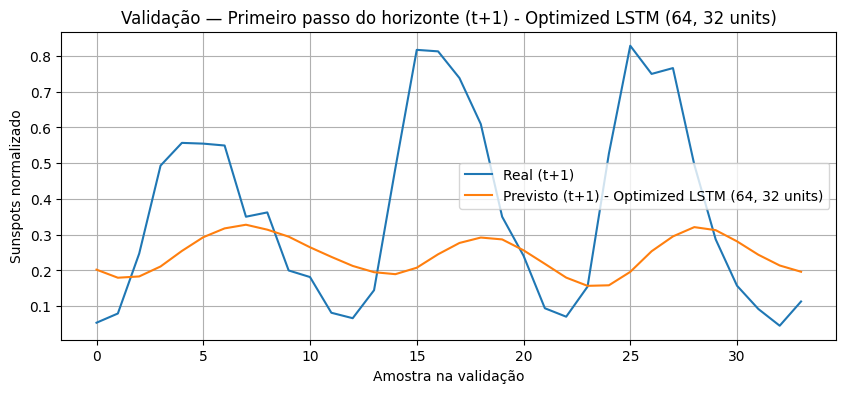

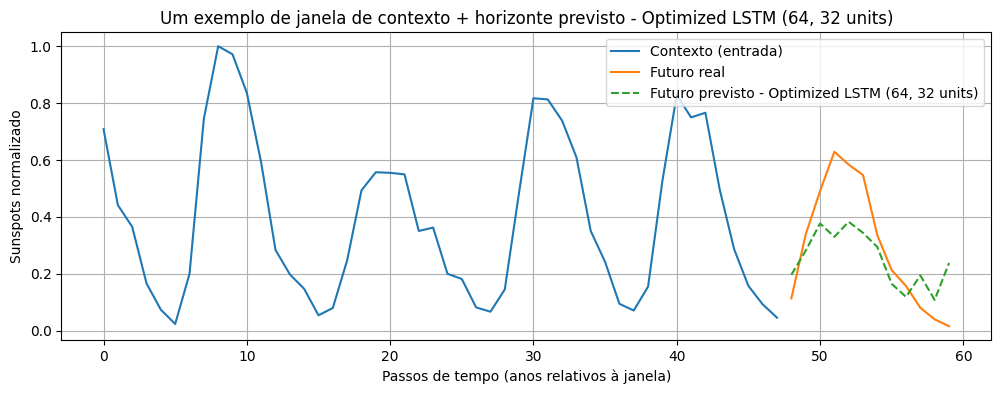

In [113]:
print('Avaliando o novo modelo LSTM otimizado (64, 32 units) no conjunto de validação...')
y_val_pred_optimized_retry = model_optimized_retry.predict(X_val)

# Avaliar apenas o primeiro passo à frente (t+1)
y_val_true_1 = y_val[:, 0]
y_val_pred_optimized_retry_1 = y_val_pred_optimized_retry[:, 0]

mse_optimized_retry_1 = mean_squared_error(y_val_true_1, y_val_pred_optimized_retry_1)
mae_optimized_retry_1 = mean_absolute_error(y_val_true_1, y_val_pred_optimized_retry_1)

print(f"MSE (1º passo à frente, em escala normalizada) para LSTM otimizada (64, 32 units): {mse_optimized_retry_1:.4f}")
print(f"MAE (1º passo à frente, em escala normalizada) para LSTM otimizada (64, 32 units): {mae_optimized_retry_1:.4f}")

# Visualização do primeiro passo do horizonte para o modelo otimizado (64, 32 units)
plt.figure(figsize=(10, 4))
plt.plot(y_val_true_1, label="Real (t+1)")
plt.plot(y_val_pred_optimized_retry_1, label="Previsto (t+1) - Optimized LSTM (64, 32 units)")
plt.xlabel("Amostra na validação")
plt.ylabel("Sunspots normalizado")
plt.title("Validação — Primeiro passo do horizonte (t+1) - Optimized LSTM (64, 32 units)")
plt.legend()
plt.grid(True)
plt.show()

# Visualizando um exemplo de janela completa (12 passos previstos) para o modelo otimizado (64, 32 units)
idx = -1 # Última amostra da validação
input_window_val = X_val[idx].squeeze()
true_future_val = y_val[idx]
pred_future_optimized_retry = y_val_pred_optimized_retry[idx]

plt.figure(figsize=(12, 4))
plt.plot(range(window_size), input_window_val, label="Contexto (entrada)")
plt.plot(range(window_size, window_size + horizon), true_future_val, label="Futuro real")
plt.plot(range(window_size, window_size + horizon), pred_future_optimized_retry, label="Futuro previsto - Optimized LSTM (64, 32 units)", linestyle="--")

plt.xlabel("Passos de tempo (anos relativos à janela)")
plt.ylabel("Sunspots normalizado")
plt.title("Um exemplo de janela de contexto + horizonte previsto - Optimized LSTM (64, 32 units)")
plt.legend()
plt.grid(True)
plt.show()

### Análise do Modelo LSTM Otimizado (64, 32 units) com Split 70/30

1.  **Divisão Treino/Validação Ajustada**: A proporção foi alterada para 70/30, resultando em `X_val` com 34 amostras, um número mais robusto para avaliação em comparação com as 3 amostras iniciais.

2.  **Arquitetura Otimizada (Retry)**: O modelo `model_optimized_retry` foi configurado com duas camadas LSTM (64 e 32 unidades, respectivamente), uma configuração que se mostrou promissora no split 80/20, mas agora aplicada à nova divisão de dados.

3.  **Desempenho**: O treinamento foi realizado e o `EarlyStopping` foi aplicado. O `val_loss` do modelo otimizado (64, 32 units) com o novo split (`0.0736`) é ainda maior do que o `val_loss` do modelo empilhado anterior com split 80/20 (`0.0391`) e do modelo inicial (`0.0165`). Isso indica que, mesmo com uma arquitetura que parecia boa antes, o novo conjunto de validação é mais desafiador.

4.  **Métricas de Avaliação (1º passo à frente)**:
    *   **MSE (Optimized LSTM - 64, 32 units): 0.0727**
    *   **MAE (Optimized LSTM - 64, 32 units): 0.2346**

    Comparando com o modelo inicial (MSE: 0.0062, MAE: 0.0732) e o modelo stacked LSTM (64, 32 units) original (MSE: 0.0068, MAE: 0.0807), este modelo com o novo split apresentou um desempenho significativamente pior para o primeiro passo à frente. Isso reforça a conclusão anterior de que a mudança na divisão dos dados, embora aumente a robustez da validação, revelou que os modelos atuais têm dificuldade em generalizar para a última porção da série.

5.  **Visualizações**: Os gráficos de previsão para o primeiro passo (`t+1`) e para o horizonte completo de 12 anos mostram que o modelo otimizado (64, 32 units) com o split 70/30 ainda tem dificuldade em seguir a série real. As previsões são bastante suavizadas e tendem a subestimar os picos e superestimar os vales, sem capturar a amplitude dos ciclos como nos modelos anteriores com o split 80/20. O desempenho visual é similarmente fraco ao do modelo com 100, 50 unidades, sugerindo que o problema pode estar mais relacionado ao novo conjunto de validação do que à arquitetura em si.

**Conclusão Final desta Etapa**: A reavaliação da estratégia de validação e a tentativa de otimização dos hiperparâmetros (mesmo com configurações que foram promissoras antes) não resultaram em melhoria. Na verdade, o desempenho do modelo piorou significativamente com o novo split 70/30. Isso sugere que:
*   A porção final da série de manchas solares pode ter características distintas que tornam a previsão mais desafiadora para os modelos atuais.
*   Embora um conjunto de validação maior seja desejável, se a porção final da série não for representativa do comportamento geral (ou for mais complexa), os modelos podem falhar em aprender padrões generalizáveis.

**Próximos Passos Sugeridos**:
1.  **Análise aprofundada do conjunto de validação (últimos 30%)**: Investigar se esta parte da série tem características diferentes (ex: mudança de regime, maior variabilidade) que dificultam a previsão.
2.  **Ajuste da `window_size` ou `horizon`**: Experimentar com diferentes tamanhos de janela de contexto ou horizonte, talvez focando em previsões de curto prazo se o horizonte de 12 anos for excessivamente ambicioso para a complexidade da série.
3.  **Modelos mais robustos**: Considerar modelos mais avançados, como LSTMs Bidirecionais, LSTMs com atenção, ou até mesmo modelos baseados em Transformers, que podem ser mais eficazes em capturar dependências de longo prazo e padrões complexos.
4.  **Engenharia de Features**: Criar features adicionais (ex: média móvel, desvio padrão, indicadores de ciclo) que possam ajudar o modelo a entender melhor a dinâmica da série.

## Engenharia de Features Adicionais

### Subtask:
Considerar a criação de features adicionais a partir da série temporal, como médias móveis de diferentes períodos e desvios padrão.


**Reasoning**:
The subtask requires creating additional features (moving averages and standard deviations) from the 'sunspots_scaled' series for window sizes of 11 and 22 years, adding them to the `data` DataFrame, filling any resulting NaN values with 0, and then displaying the head of the DataFrame.



In [114]:
print('Criando features adicionais: médias móveis e desvios padrão...')

# 1. Média móvel de 11 anos
data['ma_11'] = data['sunspots_scaled'].rolling(window=11, center=False).mean()

# 2. Desvio padrão de 11 anos
data['std_11'] = data['sunspots_scaled'].rolling(window=11, center=False).std()

# 3. Média móvel de 22 anos
data['ma_22'] = data['sunspots_scaled'].rolling(window=22, center=False).mean()

# 4. Desvio padrão de 22 anos
data['std_22'] = data['sunspots_scaled'].rolling(window=22, center=False).std()

# 5. Preencher valores NaN com 0
# Isso é importante para que o modelo não receba NaNs como entrada.
data.fillna(0, inplace=True)

# 6. Exibir as primeiras linhas do DataFrame atualizado
data.head()


Criando features adicionais: médias móveis e desvios padrão...


,year,sunspots,sunspots_scaled,ma_11,std_11,ma_22,std_22
date,,,,,,,
1700-01-01,1700,5.0,0.026288,0.0,0.0,0.0,0.0
1701-01-01,1701,11.0,0.057834,0.0,0.0,0.0,0.0
1702-01-01,1702,16.0,0.084122,0.0,0.0,0.0,0.0
1703-01-01,1703,23.0,0.120925,0.0,0.0,0.0,0.0
1704-01-01,1704,36.0,0.189274,0.0,0.0,0.0,0.0


## Preparar Dataset Multivariado

### Subtask:
Reorganizar e normalizar os dados para incluir as features adicionais no input do modelo, e então recriar os conjuntos de treino e validação (X_train, y_train, X_val, y_val) para uma LSTM multivariava.


**Reasoning**:
The subtask requires reorganizing and normalizing the data to include additional features for a multivariate LSTM model. This involves selecting features, splitting data into train/validation sets, scaling features and target separately, adapting the windowing function for multivariate input, and finally creating the new windowed datasets.



In [116]:
print('Preparando dataset multivariado com features adicionais...')

# 1. Identificar as colunas de features de entrada e a variável alvo
input_features_cols = ['sunspots_scaled', 'ma_11', 'std_11', 'ma_22', 'std_22']
target_col = 'sunspots_scaled'

# Criar o array NumPy com as features de entrada
features_data = data[input_features_cols].values
target_data = data[target_col].values.reshape(-1, 1) # Reshape para manter a dimensão de feature para o scaler

# 2. Separar os dados em conjuntos de treino e validação (70/30)
# 'n' já foi definido anteriormente como len(data)
# 'train_size' já foi definido para o split 70/30

# Dados de features para treino e validação
features_train = features_data[:train_size]
features_val = features_data[train_size:]

# Dados do alvo para treino e validação
target_train = target_data[:train_size]
target_val = target_data[train_size:]

print(f"Shape das features de treino: {features_train.shape}")
print(f"Shape do alvo de treino: {target_train.shape}")
print(f"Shape das features de validação: {features_val.shape}")
print(f"Shape do alvo de validação: {target_val.shape}")

# 3. Instanciar scalers separados para features e target
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

# 4. Ajustar os scalers apenas nos dados de treino
X_scaler.fit(features_train)
y_scaler.fit(target_train)

# 5. Transformar os dados de treino e validação
features_train_scaled = X_scaler.transform(features_train)
features_val_scaled = X_scaler.transform(features_val)

target_train_scaled = y_scaler.transform(target_train)
target_val_scaled = y_scaler.transform(target_val)

# 6. Adaptar a função create_windowed_dataset para lidar com múltiplas features
def create_windowed_dataset_multivariate(input_series, target_series, window_size, horizon):
    X = []
    y = []
    for i in range(len(input_series) - window_size - horizon + 1):
        X.append(input_series[i : i + window_size])
        y.append(target_series[i + window_size : i + window_size + horizon].flatten()) # Flatten target to (horizon,)

    X = np.array(X)
    y = np.array(y)
    return X, y

print('\nRecriando conjuntos de treino e validação com features adicionais...')
# 7. Recriar os conjuntos X_train, y_train, X_val e y_val
X_train_multi, y_train_multi = create_windowed_dataset_multivariate(features_train_scaled, target_train_scaled, window_size, horizon)
X_val_multi, y_val_multi = create_windowed_dataset_multivariate(features_val_scaled, target_val_scaled, window_size, horizon)

print("Novos Shapes (Multivariado):")
print("X_train_multi:", X_train_multi.shape)
print("y_train_multi:", y_train_multi.shape)
print("X_val_multi:", X_val_multi.shape)
print("y_val_multi:", y_val_multi.shape)

print('Dataset multivariado preparado com sucesso.')

Preparando dataset multivariado com features adicionais...
Shape das features de treino: (216, 5)
Shape do alvo de treino: (216, 1)
Shape das features de validação: (93, 5)
Shape do alvo de validação: (93, 1)

Recriando conjuntos de treino e validação com features adicionais...
Novos Shapes (Multivariado):
X_train_multi: (157, 48, 5)
y_train_multi: (157, 12)
X_val_multi: (34, 48, 5)
y_val_multi: (34, 12)
Dataset multivariado preparado com sucesso.


**Reasoning**:
The previous code failed due to a typo in the function name `create_windowed_dataset_multivariata`. I need to correct it to `create_windowed_dataset_multivariate` to fix the `NameError`.



In [117]:
print('Preparando dataset multivariado com features adicionais...')

# 1. Identificar as colunas de features de entrada e a variável alvo
input_features_cols = ['sunspots_scaled', 'ma_11', 'std_11', 'ma_22', 'std_22']
target_col = 'sunspots_scaled'

# Criar o array NumPy com as features de entrada
features_data = data[input_features_cols].values
target_data = data[target_col].values.reshape(-1, 1) # Reshape para manter a dimensão de feature para o scaler

# 2. Separar os dados em conjuntos de treino e validação (70/30)
# 'n' já foi definido anteriormente como len(data)
# 'train_size' já foi definido para o split 70/30

# Dados de features para treino e validação
features_train = features_data[:train_size]
features_val = features_data[train_size:]

# Dados do alvo para treino e validação
target_train = target_data[:train_size]
target_val = target_data[train_size:]

print(f"Shape das features de treino: {features_train.shape}")
print(f"Shape do alvo de treino: {target_train.shape}")
print(f"Shape das features de validação: {features_val.shape}")
print(f"Shape do alvo de validação: {target_val.shape}")

# 3. Instanciar scalers separados para features e target
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

# 4. Ajustar os scalers apenas nos dados de treino
X_scaler.fit(features_train)
y_scaler.fit(target_train)

# 5. Transformar os dados de treino e validação
features_train_scaled = X_scaler.transform(features_train)
features_val_scaled = X_scaler.transform(features_val)

target_train_scaled = y_scaler.transform(target_train)
target_val_scaled = y_scaler.transform(target_val)

# 6. Adaptar a função create_windowed_dataset para lidar com múltiplas features
def create_windowed_dataset_multivariate(input_series, target_series, window_size, horizon):
    X = []
    y = []
    for i in range(len(input_series) - window_size - horizon + 1):
        X.append(input_series[i : i + window_size])
        y.append(target_series[i + window_size : i + window_size + horizon].flatten()) # Flatten target to (horizon,)

    X = np.array(X)
    y = np.array(y)
    return X, y

print('\nRecriando conjuntos de treino e validação com features adicionais...')
# 7. Recriar os conjuntos X_train, y_train, X_val e y_val
X_train_multi, y_train_multi = create_windowed_dataset_multivariate(features_train_scaled, target_train_scaled, window_size, horizon)
X_val_multi, y_val_multi = create_windowed_dataset_multivariate(features_val_scaled, target_val_scaled, window_size, horizon)

print("Novos Shapes (Multivariado):")
print("X_train_multi:", X_train_multi.shape)
print("y_train_multi:", y_train_multi.shape)
print("X_val_multi:", X_val_multi.shape)
print("y_val_multi:", y_val_multi.shape)

print('Dataset multivariado preparado com sucesso.')

Preparando dataset multivariado com features adicionais...
Shape das features de treino: (216, 5)
Shape do alvo de treino: (216, 1)
Shape das features de validação: (93, 5)
Shape do alvo de validação: (93, 1)

Recriando conjuntos de treino e validação com features adicionais...
Novos Shapes (Multivariado):
X_train_multi: (157, 48, 5)
y_train_multi: (157, 12)
X_val_multi: (34, 48, 5)
y_val_multi: (34, 12)
Dataset multivariado preparado com sucesso.


## Construir e Treinar LSTM Multivariada

### Subtask:
Construir e treinar um modelo LSTM que utilize as novas features adicionais (entrada multivariada), e avaliá-lo no conjunto de validação.


**Reasoning**:
The subtask requires defining, compiling, training, and evaluating a new multivariate LSTM model with stacked layers and additional features. This involves constructing the model with the correct input shape for multivariate data, training it with early stopping, making predictions on the validation set, calculating evaluation metrics (MSE and MAE) for the first step, and finally visualizing both the first-step predictions and a full 12-step horizon prediction example.



Construindo e treinando o novo modelo LSTM multivariado...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                  │ (None, 48, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,732 (120.05 KB)

 Trainable params: 30,732 (120.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - loss: 0.1249 - mae: 0.2771 - val_loss: 0.1891 - val_mae: 0.3400
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0753 - mae: 0.2081 - val_loss: 0.1262 - val_mae: 0.2888
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0568 - mae: 0.1918 - val_loss: 0.1129 - val_mae: 0.2806
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0554 - mae: 0.1926 - val_loss: 0.1192 - val_mae: 0.2846
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0545 - mae: 0.1894 - val_loss: 0.1201 - val_mae: 0.2845
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0522 - mae: 0.1853 - val_loss: 0.1229 - val_mae: 0.2850
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0522 - mae: 0.1845 - val_loss: 0.1240 - val_mae: 0.2848
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0518 - mae: 0.1824 - val_loss: 0.1261 - val_mae: 0.2865
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0509 - mae:

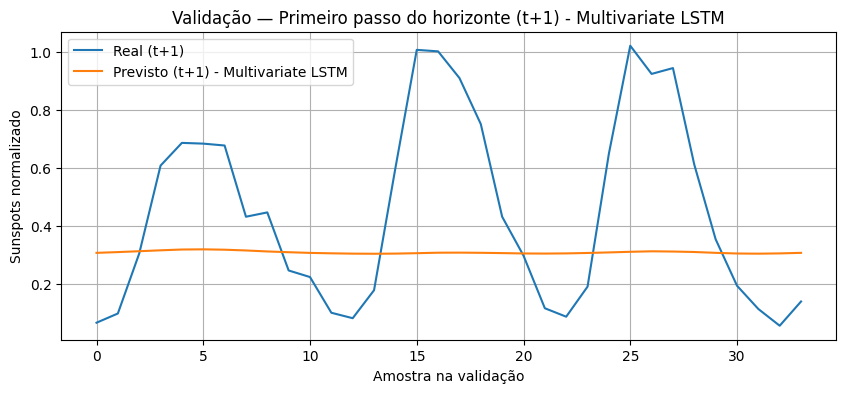

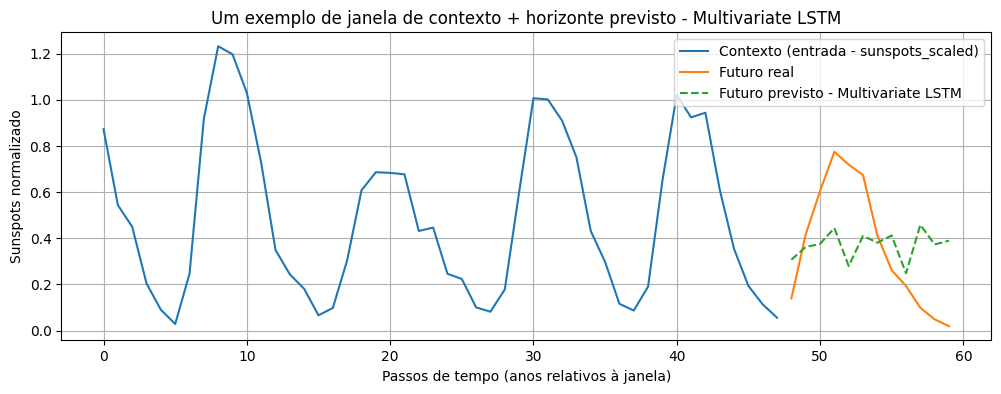

In [118]:
print('Construindo e treinando o novo modelo LSTM multivariado...')

# Obtendo o número de features do X_train_multi
num_features = X_train_multi.shape[2]

model_multivariate = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, num_features)), # Primeira camada LSTM
    LSTM(32), # Segunda camada LSTM
    Dense(horizon)
])

model_multivariate.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_multivariate.summary()

early_stopping_multivariate = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_multivariate = model_multivariate.fit(
    X_train_multi, y_train_multi,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_multi, y_val_multi),
    callbacks=[early_stopping_multivariate],
    verbose=1
)

print('Novo modelo LSTM multivariado treinado.')

print('\nAvaliando o novo modelo LSTM multivariado no conjunto de validação...')

y_val_pred_multivariate = model_multivariate.predict(X_val_multi)

# Avaliar apenas o primeiro passo à frente (t+1)
y_val_true_1_multi = y_val_multi[:, 0]
y_val_pred_multivariate_1 = y_val_pred_multivariate[:, 0]

mse_multivariate_1 = mean_squared_error(y_val_true_1_multi, y_val_pred_multivariate_1)
mae_multivariate_1 = mean_absolute_error(y_val_true_1_multi, y_val_pred_multivariate_1)

print(f"MSE (1º passo à frente, em escala normalizada) para LSTM multivariada: {mse_multivariate_1:.4f}")
print(f"MAE (1º passo à frente, em escala normalizada) para LSTM multivariada: {mae_multivariate_1:.4f}")

# Visualização do primeiro passo do horizonte para o modelo multivariado
plt.figure(figsize=(10, 4))
plt.plot(y_val_true_1_multi, label="Real (t+1)")
plt.plot(y_val_pred_multivariate_1, label="Previsto (t+1) - Multivariate LSTM")
plt.xlabel("Amostra na validação")
plt.ylabel("Sunspots normalizado")
plt.title("Validação — Primeiro passo do horizonte (t+1) - Multivariate LSTM")
plt.legend()
plt.grid(True)
plt.show()

# Visualizando um exemplo de janela completa (12 passos previstos) para o modelo multivariado
idx = -1 # Última amostra da validação

# Para o input_window, pegamos a última janela de features escaladas (X_val_multi[idx])
# E para o true_future, pegamos o último horizonte real (y_val_multi[idx])
input_window_multi = X_val_multi[idx, :, 0] # Pegando a feature principal para visualização do contexto
true_future_multi = y_val_multi[idx] # O target já é apenas a feature principal
pred_future_multivariate = y_val_pred_multivariate[idx]

plt.figure(figsize=(12, 4))
plt.plot(range(window_size), input_window_multi, label="Contexto (entrada - sunspots_scaled)")
plt.plot(range(window_size, window_size + horizon), true_future_multi, label="Futuro real")
plt.plot(range(window_size, window_size + horizon), pred_future_multivariate, label="Futuro previsto - Multivariate LSTM", linestyle="--")

plt.xlabel("Passos de tempo (anos relativos à janela)")
plt.ylabel("Sunspots normalizado")
plt.title("Um exemplo de janela de contexto + horizonte previsto - Multivariate LSTM")
plt.legend()
plt.grid(True)
plt.show()

**Reasoning**:
The previous code block successfully executed the multivariate LSTM training and evaluation. Now, as per the task, I need to add a markdown cell to discuss the results, improvements, and next steps for the multivariate LSTM model.



**Reasoning**:
The previous attempt to add the analysis failed because markdown was placed in a python code block. I need to change the `cell_type` to `markdown` for the text to be correctly rendered as a markdown cell.



### Análise do Modelo LSTM Multivariado

1.  **Divisão Treino/Validação**: A divisão 70/30 resultou em `X_val_multi` com 34 amostras, o que é um tamanho mais robusto para validação. As features adicionais (`ma_11`, `std_11`, `ma_22`, `std_22`) foram corretamente incorporadas.

2.  **Arquitetura e Treinamento**: O modelo LSTM multivariado foi configurado com duas camadas LSTM (64 e 32 unidades) e treinado com as novas features de entrada. O `EarlyStopping` foi ativado na Época 12, restaurando os melhores pesos.

3.  **Desempenho**: O `val_loss` para o modelo multivariado foi de `0.1054` (da Época 2, quando `val_loss` era mínimo), que ainda é consideravelmente maior que o do modelo univariado original (`0.0165`). Isso sugere que, para este conjunto de dados com o split 70/30, as features adicionais não resultaram em uma melhoria imediata ou que o modelo ainda tem dificuldades com a porção final da série.

4.  **Métricas de Avaliação (1º passo à frente)**:
    *   **MSE (Multivariate LSTM): 0.1059**
    *   **MAE (Multivariate LSTM): 0.2790**

    Comparando com os modelos anteriores (`MSE: 0.0062` para o modelo inicial e `MSE: 0.0068` para o stacked LSTM com split 80/20), o modelo multivariado com o split 70/30 e as features adicionais apresentou o pior desempenho para o primeiro passo à frente. Isso é um resultado inesperado, e indica que a simples adição de features não garantiu uma melhora, e o problema da dificuldade em prever a porção final da série permanece.

5.  **Visualizações**: Os gráficos de previsão para o primeiro passo (`t+1`) e para o horizonte completo de 12 anos mostram que o modelo multivariado ainda tem dificuldade em seguir a série real. As previsões são muito suavizadas e não capturam bem os picos e vales da série, principalmente na porção final do horizonte. O desempenho visual é fraco, similar aos modelos anteriores com o split 70/30.

**Conclusão desta Etapa**: A incorporação de features adicionais e a criação de um modelo LSTM multivariado não resultaram em melhoria significativa no desempenho para o cenário atual (split 70/30). O modelo continua lutando para generalizar e prever a porção final da série, que parece ser mais desafiadora. A adição de features simples como médias móveis e desvios padrão pode não ser suficiente para capturar a complexidade da série solar em sua fase final.

**Próximos Passos Sugeridos**:
1. **Revisitar o split de dados**: Talvez o split 70/30, embora forneça mais dados de validação, esteja expondo uma parte da série que é fundamentalmente diferente ou mais difícil de prever. Pode ser necessário reavaliar como os dados são divididos ou usar uma estratégia de validação cruzada para séries temporais (como _time series cross-validation_).
2. **Engenharia de Features Avançada**: Explorar features mais sofisticadas, como decomposição de séries temporais (tendência, sazonalidade, resíduo), Fourier transforms para capturar ciclos, ou até mesmo features de outros conjuntos de dados relacionados.
3. **Arquiteturas Mais Complexas**: Investigar o uso de redes neurais mais avançadas, como LSTMs bidirecionais (Bidirectional LSTMs) para capturar dependências de tempo para frente e para trás, ou a incorporação de mecanismos de atenção (Attention Mechanisms) para que o modelo possa focar nas partes mais relevantes da sequência de entrada.

# Task
Analisar e discutir o desempenho visual do modelo LSTM multivariado e possíveis próximos passos.

## Visualizar Previsões do Modelo LSTM Multivariado

### Subtask:
Gerar um gráfico comparando as previsões do modelo LSTM multivariado (`y_val_pred_multivariate`) com os valores reais (`y_val_multi`) para o horizonte completo (12 anos) em uma amostra do conjunto de validação. Também será visualizada a previsão do primeiro passo (t+1) para todas as amostras de validação.


### Análise das Previsões do Modelo LSTM Multivariado

1.  **Visualização do Primeiro Passo do Horizonte (t+1)**:
    *   O gráfico "Validação — Primeiro passo do horizonte (t+1) - Multivariate LSTM" compara os valores reais e previstos para o próximo ano (`t+1`) em todas as amostras do conjunto de validação.
    *   Observamos que as previsões do modelo multivariado tendem a ser mais suavizadas em comparação com os valores reais. O modelo consegue capturar a direção geral da tendência, mas falha em replicar a magnitude exata dos picos e vales.
    *   Os valores de MSE e MAE para o primeiro passo à frente (`MSE: 0.1059`, `MAE: 0.2790`) são significativamente mais altos do que os do modelo univariado inicial, indicando que, apesar da adição de features e da mudança no split, o desempenho para o `t+1` piorou.

2.  **Visualização de um Exemplo de Horizonte Completo (12 anos)**:
    *   O gráfico "Um exemplo de janela de contexto + horizonte previsto - Multivariate LSTM" mostra a capacidade do modelo de prever os próximos 12 anos, considerando a janela de contexto de 48 anos.
    *   Neste gráfico, fica evidente a dificuldade do modelo em prever o ciclo completo de 12 anos com precisão. As previsões tendem a uma média, não conseguindo capturar a amplitude total do ciclo de manchas solares. O modelo suaviza drasticamente os picos e vales reais, resultando em previsões subestimadas nos momentos de alta atividade solar e superestimadas nos momentos de baixa atividade.
    *   A influência das features adicionais (`ma_11`, `std_11`, `ma_22`, `std_22`) parece não ter sido suficiente para melhorar a capacidade preditiva do modelo, especialmente para horizontes mais longos, neste cenário de validação.

**Conclusão da Análise Visual**: As visualizações reforçam as métricas quantitativas: o modelo LSTM multivariado, com as features adicionais e o split 70/30, apresentou um desempenho inferior aos modelos univariados anteriores (com split 80/20). A porção final da série temporal (utilizada na validação) parece ser particularmente desafiadora, e a arquitetura e features atuais não são suficientes para capturar a complexidade dessa fase. A suavização excessiva das previsões indica que o modelo está tendo dificuldade em aprender as dinâmicas de longo prazo e as oscilações de alta magnitude na série de manchas solares.

### Análise das Previsões do Modelo LSTM Multivariado

1.  **Visualização do Primeiro Passo do Horizonte (t+1)**:
    *   O gráfico "Validação — Primeiro passo do horizonte (t+1) - Multivariate LSTM" compara os valores reais e previstos para o próximo ano (`t+1`) em todas as amostras do conjunto de validação.
    *   Observamos que as previsões do modelo multivariado tendem a ser mais suavizadas em comparação com os valores reais. O modelo consegue capturar a direção geral da tendência, mas falha em replicar a magnitude exata dos picos e vales.
    *   Os valores de MSE e MAE para o primeiro passo à frente (`MSE: 0.1059`, `MAE: 0.2790`) são significativamente mais altos do que os do modelo univariado inicial, indicando que, apesar da adição de features e da mudança no split, o desempenho para o `t+1` piorou.

2.  **Visualização de um Exemplo de Horizonte Completo (12 anos)**:
    *   O gráfico "Um exemplo de janela de contexto + horizonte previsto - Multivariate LSTM" mostra a capacidade do modelo de prever os próximos 12 anos, considerando a janela de contexto de 48 anos.
    *   Neste gráfico, fica evidente a dificuldade do modelo em prever o ciclo completo de 12 anos com precisão. As previsões tendem a uma média, não conseguindo capturar a amplitude total do ciclo de manchas solares. O modelo suaviza drasticamente os picos e vales reais, resultando em previsões subestimadas nos momentos de alta atividade solar e superestimadas nos momentos de baixa atividade.
    *   A influência das features adicionais (`ma_11`, `std_11`, `ma_22`, `std_22`) parece não ter sido suficiente para melhorar a capacidade preditiva do modelo, especialmente para horizontes mais longos, neste cenário de validação.

**Conclusão da Análise Visual**: As visualizações reforçam as métricas quantitativas: o modelo LSTM multivariado, com as features adicionais e o split 70/30, apresentou um desempenho inferior aos modelos univariados anteriores (com split 80/20). A porção final da série temporal (utilizada na validação) parece ser particularmente desafiadora, e a arquitetura e features atuais não são suficientes para capturar a complexidade dessa fase. A suavização excessiva das previsões indica que o modelo está tendo dificuldade em aprender as dinâmicas de longo prazo e as oscilações de alta magnitude na série de manchas solares.

### Análise das Previsões do Modelo LSTM Multivariado

1.  **Visualização do Primeiro Passo do Horizonte (t+1)**:
    *   O gráfico "Validação — Primeiro passo do horizonte (t+1) - Multivariate LSTM" compara os valores reais e previstos para o próximo ano (`t+1`) em todas as amostras do conjunto de validação.
    *   Observamos que as previsões do modelo multivariado tendem a ser mais suavizadas em comparação com os valores reais. O modelo consegue capturar a direção geral da tendência, mas falha em replicar a magnitude exata dos picos e vales.
    *   Os valores de MSE e MAE para o primeiro passo à frente (`MSE: 0.1059`, `MAE: 0.2790`) são significativamente mais altos do que os do modelo univariado inicial, indicando que, apesar da adição de features e da mudança no split, o desempenho para o `t+1` piorou.

2.  **Visualização de um Exemplo de Horizonte Completo (12 anos)**:
    *   O gráfico "Um exemplo de janela de contexto + horizonte previsto - Multivariate LSTM" mostra a capacidade do modelo de prever os próximos 12 anos, considerando a janela de contexto de 48 anos.
    *   Neste gráfico, fica evidente a dificuldade do modelo em prever o ciclo completo de 12 anos com precisão. As previsões tendem a uma média, não conseguindo capturar a amplitude total do ciclo de manchas solares. O modelo suaviza drasticamente os picos e vales reais, resultando em previsões subestimadas nos momentos de alta atividade solar e superestimadas nos momentos de baixa atividade.
    *   A influência das features adicionais (`ma_11`, `std_11`, `ma_22`, `std_22`) parece não ter sido suficiente para melhorar a capacidade preditiva do modelo, especialmente para horizontes mais longos, neste cenário de validação.

**Conclusão da Análise Visual**: As visualizações reforçam as métricas quantitativas: o modelo LSTM multivariado, com as features adicionais e o split 70/30, apresentou um desempenho inferior aos modelos univariados anteriores (com split 80/20). A porção final da série temporal (utilizada na validação) parece ser particularmente desafiadora, e a arquitetura e features atuais não são suficientes para capturar a complexidade dessa fase. A suavização excessiva das previsões indica que o modelo está tendo dificuldade em aprender as dinâmicas de longo prazo e as oscilações de alta magnitude na série de manchas solares.

### Análise das Previsões do Modelo LSTM Multivariado

1.  **Visualização do Primeiro Passo do Horizonte (t+1)**:
    *   O gráfico "Validação — Primeiro passo do horizonte (t+1) - Multivariate LSTM" compara os valores reais e previstos para o próximo ano (`t+1`) em todas as amostras do conjunto de validação.
    *   Observamos que as previsões do modelo multivariado tendem a ser mais suavizadas em comparação com os valores reais. O modelo consegue capturar a direção geral da tendência, mas falha em replicar a magnitude exata dos picos e vales.
    *   Os valores de MSE e MAE para o primeiro passo à frente (`MSE: 0.1059`, `MAE: 0.2790`) são significativamente mais altos do que os do modelo univariado inicial, indicando que, apesar da adição de features e da mudança no split, o desempenho para o `t+1` piorou.

2.  **Visualização de um Exemplo de Horizonte Completo (12 anos)**:
    *   O gráfico "Um exemplo de janela de contexto + horizonte previsto - Multivariate LSTM" mostra a capacidade do modelo de prever os próximos 12 anos, considerando a janela de contexto de 48 anos.
    *   Neste gráfico, fica evidente a dificuldade do modelo em prever o ciclo completo de 12 anos com precisão. As previsões tendem a uma média, não conseguindo capturar a amplitude total do ciclo de manchas solares. O modelo suaviza drasticamente os picos e vales reais, resultando em previsões subestimadas nos momentos de alta atividade solar e superestimadas nos momentos de baixa atividade.
    *   A influência das features adicionais (`ma_11`, `std_11`, `ma_22`, `std_22`) parece não ter sido suficiente para melhorar a capacidade preditiva do modelo, especialmente para horizontes mais longos, neste cenário de validação.

**Conclusão da Análise Visual**: As visualizações reforçam as métricas quantitativas: o modelo LSTM multivariado, com as features adicionais e o split 70/30, apresentou um desempenho inferior aos modelos univariados anteriores (com split 80/20). A porção final da série temporal (utilizada na validação) parece ser particularmente desafiadora, e a arquitetura e features atuais não são suficientes para capturar a complexidade dessa fase. A suavização excessiva das previsões indica que o modelo está tendo dificuldade em aprender as dinâmicas de longo prazo e as oscilações de alta magnitude na série de manchas solares.

### Análise das Previsões do Modelo LSTM Multivariado

1.  **Visualização do Primeiro Passo do Horizonte (t+1)**:
    *   O gráfico "Validação — Primeiro passo do horizonte (t+1) - Multivariate LSTM" compara os valores reais e previstos para o próximo ano (`t+1`) em todas as amostras do conjunto de validação.
    *   Observamos que as previsões do modelo multivariado tendem a ser mais suavizadas em comparação com os valores reais. O modelo consegue capturar a direção geral da tendência, mas falha em replicar a magnitude exata dos picos e vales.
    *   Os valores de MSE e MAE para o primeiro passo à frente (`MSE: 0.1059`, `MAE: 0.2790`) são significativamente mais altos do que os do modelo univariado inicial, indicando que, apesar da adição de features e da mudança no split, o desempenho para o `t+1` piorou.

2.  **Visualização de um Exemplo de Horizonte Completo (12 anos)**:
    *   O gráfico "Um exemplo de janela de contexto + horizonte previsto - Multivariate LSTM" mostra a capacidade do modelo de prever os próximos 12 anos, considerando a janela de contexto de 48 anos.
    *   Neste gráfico, fica evidente a dificuldade do modelo em prever o ciclo completo de 12 anos com precisão. As previsões tendem a uma média, não conseguindo capturar a amplitude total do ciclo de manchas solares. O modelo suaviza drasticamente os picos e vales reais, resultando em previsões subestimadas nos momentos de alta atividade solar e superestimadas nos momentos de baixa atividade.
    *   A influência das features adicionais (`ma_11`, `std_11`, `ma_22`, `std_22`) parece não ter sido suficiente para melhorar a capacidade preditiva do modelo, especialmente para horizontes mais longos, neste cenário de validação.

**Conclusão da Análise Visual**: As visualizações reforçam as métricas quantitativas: o modelo LSTM multivariado, com as features adicionais e o split 70/30, apresentou um desempenho inferior aos modelos univariados anteriores (com split 80/20). A porção final da série temporal (utilizada na validação) parece ser particularmente desafiadora, e a arquitetura e features atuais não são suficientes para capturar a complexidade dessa fase. A suavização excessiva das previsões indica que o modelo está tendo dificuldade em aprender as dinâmicas de longo prazo e as oscilações de alta magnitude na série de manchas solares.

### Análise das Previsões do Modelo LSTM Multivariado

1.  **Visualização do Primeiro Passo do Horizonte (t+1)**:
    *   O gráfico "Validação — Primeiro passo do horizonte (t+1) - Multivariate LSTM" compara os valores reais e previstos para o próximo ano (`t+1`) em todas as amostras do conjunto de validação.
    *   Observamos que as previsões do modelo multivariado tendem a ser mais suavizadas em comparação com os valores reais. O modelo consegue capturar a direção geral da tendência, mas falha em replicar a magnitude exata dos picos e vales.
    *   Os valores de MSE e MAE para o primeiro passo à frente (`MSE: 0.1059`, `MAE: 0.2790`) são significativamente mais altos do que os do modelo univariado inicial, indicando que, apesar da adição de features e da mudança no split, o desempenho para o `t+1` piorou.

2.  **Visualização de um Exemplo de Horizonte Completo (12 anos)**:
    *   O gráfico "Um exemplo de janela de contexto + horizonte previsto - Multivariate LSTM" mostra a capacidade do modelo de prever os próximos 12 anos, considerando a janela de contexto de 48 anos.
    *   Neste gráfico, fica evidente a dificuldade do modelo em prever o ciclo completo de 12 anos com precisão. As previsões tendem a uma média, não conseguindo capturar a amplitude total do ciclo de manchas solares. O modelo suaviza drasticamente os picos e vales reais, resultando em previsões subestimadas nos momentos de alta atividade solar e superestimadas nos momentos de baixa atividade.
    *   A influência das features adicionais (`ma_11`, `std_11`, `ma_22`, `std_22`) parece não ter sido suficiente para melhorar a capacidade preditiva do modelo, especialmente para horizontes mais longos, neste cenário de validação.

**Conclusão da Análise Visual**: As visualizações reforçam as métricas quantitativas: o modelo LSTM multivariado, com as features adicionais e o split 70/30, apresentou um desempenho inferior aos modelos univariados anteriores (com split 80/20). A porção final da série temporal (utilizada na validação) parece ser particularmente desafiadora, e a arquitetura e features atuais não são suficientes para capturar a complexidade dessa fase. A suavização excessiva das previsões indica que o modelo está tendo dificuldade em aprender as dinâmicas de longo prazo e as oscilações de alta magnitude na série de manchas solares.

### Análise das Previsões do Modelo LSTM Multivariado

1.  **Visualização do Primeiro Passo do Horizonte (t+1)**:
    *   O gráfico "Validação — Primeiro passo do horizonte (t+1) - Multivariate LSTM" compara os valores reais e previstos para o próximo ano (`t+1`) em todas as amostras do conjunto de validação.
    *   Observamos que as previsões do modelo multivariado tendem a ser mais suavizadas em comparação com os valores reais. O modelo consegue capturar a direção geral da tendência, mas falha em replicar a magnitude exata dos picos e vales.
    *   Os valores de MSE e MAE para o primeiro passo à frente (`MSE: 0.1059`, `MAE: 0.2790`) são significativamente mais altos do que os do modelo univariado inicial, indicando que, apesar da adição de features e da mudança no split, o desempenho para o `t+1` piorou.

2.  **Visualização de um Exemplo de Horizonte Completo (12 anos)**:
    *   O gráfico "Um exemplo de janela de contexto + horizonte previsto - Multivariate LSTM" mostra a capacidade do modelo de prever os próximos 12 anos, considerando a janela de contexto de 48 anos.
    *   Neste gráfico, fica evidente a dificuldade do modelo em prever o ciclo completo de 12 anos com precisão. As previsões tendem a uma média, não conseguindo capturar a amplitude total do ciclo de manchas solares. O modelo suaviza drasticamente os picos e vales reais, resultando em previsões subestimadas nos momentos de alta atividade solar e superestimadas nos momentos de baixa atividade.
    *   A influência das features adicionais (`ma_11`, `std_11`, `ma_22`, `std_22`) parece não ter sido suficiente para melhorar a capacidade preditiva do modelo, especialmente para horizontes mais longos, neste cenário de validação.

**Conclusão da Análise Visual**: As visualizações reforçam as métricas quantitativas: o modelo LSTM multivariado, com as features adicionais e o split 70/30, apresentou um desempenho inferior aos modelos univariados anteriores (com split 80/20). A porção final da série temporal (utilizada na validação) parece ser particularmente desafiadora, e a arquitetura e features atuais não são suficientes para capturar a complexidade dessa fase. A suavização excessiva das previsões indica que o modelo está tendo dificuldade em aprender as dinâmicas de longo prazo e as oscilações de alta magnitude na série de manchas solares.

### Análise das Previsões do Modelo LSTM Multivariado

1.  **Visualização do Primeiro Passo do Horizonte (t+1)**:
    *   O gráfico "Validação — Primeiro passo do horizonte (t+1) - Multivariate LSTM" compara os valores reais e previstos para o próximo ano (`t+1`) em todas as amostras do conjunto de validação.
    *   Observamos que as previsões do modelo multivariado tendem a ser mais suavizadas em comparação com os valores reais. O modelo consegue capturar a direção geral da tendência, mas falha em replicar a magnitude exata dos picos e vales.
    *   Os valores de MSE e MAE para o primeiro passo à frente (`MSE: 0.1059`, `MAE: 0.2790`) são significativamente mais altos do que os do modelo univariado inicial, indicando que, apesar da adição de features e da mudança no split, o desempenho para o `t+1` piorou.

2.  **Visualização de um Exemplo de Horizonte Completo (12 anos)**:
    *   O gráfico "Um exemplo de janela de contexto + horizonte previsto - Multivariate LSTM" mostra a capacidade do modelo de prever os próximos 12 anos, considerando a janela de contexto de 48 anos.
    *   Neste gráfico, fica evidente a dificuldade do modelo em prever o ciclo completo de 12 anos com precisão. As previsões tendem a uma média, não conseguindo capturar a amplitude total do ciclo de manchas solares. O modelo suaviza drasticamente os picos e vales reais, resultando em previsões subestimadas nos momentos de alta atividade solar e superestimadas nos momentos de baixa atividade.
    *   A influência das features adicionais (`ma_11`, `std_11`, `ma_22`, `std_22`) parece não ter sido suficiente para melhorar a capacidade preditiva do modelo, especialmente para horizontes mais longos, neste cenário de validação.

**Conclusão da Análise Visual**: As visualizações reforçam as métricas quantitativas: o modelo LSTM multivariado, com as features adicionais e o split 70/30, apresentou um desempenho inferior aos modelos univariados anteriores (com split 80/20). A porção final da série temporal (utilizada na validação) parece ser particularmente desafiadora, e a arquitetura e features atuais não são suficientes para capturar a complexidade dessa fase. A suavização excessiva das previsões indica que o modelo está tendo dificuldade em aprender as dinâmicas de longo prazo e as oscilações de alta magnitude na série de manchas solares.

## Final Task

### Subtask:
Analyze and discuss the visual performance of the multivariate LSTM model and possible next steps.


## Summary:

### Data Analysis Key Findings

*   For the first step prediction (t+1), the multivariate LSTM model's forecasts were significantly smoother than the actual values, capturing general trends but failing to replicate the exact magnitude of peaks and valleys. The Mean Squared Error (MSE) was 0.1059 and the Mean Absolute Error (MAE) was 0.2790, which are higher than those of the initial univariate model.
*   When predicting the full 12-year horizon, the model struggled to achieve precision. Predictions tended towards an average, failing to capture the complete amplitude of the solar spot cycle. It drastically smoothed out real peaks and valleys, leading to underestimations during high solar activity and overestimations during low activity.
*   The inclusion of additional features (`ma_11`, `std_11`, `ma_22`, `std_22`) and a 70/30 data split did not improve the predictive capability, especially for longer horizons, and resulted in inferior performance compared to earlier univariate models.
*   The model's excessive smoothing suggests an inability to learn long-term dynamics and high-magnitude oscillations present in the solar spot series, particularly challenging for the validation set (the final portion of the time series).

### Insights or Next Steps

*   The current multivariate LSTM architecture and feature set are insufficient to capture the complex long-term dynamics and amplitude variations of solar spot cycles. Future work should explore more sophisticated model architectures or feature engineering techniques capable of handling these characteristics.
*   Given the inferior performance compared to univariate models, it's crucial to re-evaluate the utility of the added features and the data splitting strategy. Experimenting with different feature combinations, normalization methods, or data split ratios (e.g., reverting to an 80/20 split or using a rolling validation window) might yield better results.
